# Traitement automatique des données Poids (Withings HealthMate),
# Food (MyFitnessPal), et Exercices (Polar)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from zipfile import ZipFile

import datetime
import json
import re
import shutil

from tqdm import tqdm

import seaborn as sns

import ipywidgets
import os

In [2]:
# ici, aller chercher dans Download
# les fichiers commençant par data-user... , data_BEN..., etc.
# repérer les plus récents (= derniers downloads)
# et copier ces plus récents dans imports avec le nom qui va bien

# voir :
# os.listdir : liste fichiers
# os.stat_result : donne infos sur fichier x (dont date dernière modif)
# shutil.copy : copie fichier endroit X à l'endroit Y

downloads_rep = "/home/benjamin/Downloads/"
liste_downloaded_files = os.listdir(downloads_rep)

if len(liste_downloaded_files) == 0:
    raise NameError(f"Aucun fichier n'est présent dans {downloads_rep}")

In [3]:
# recherche fichiers POIDS : format data_BEN_xxxxxx.zip

# Source : Withings https://healthmate.withings.com/

# Account > User > Parameters > Download ==> data_BEN_xxxxx.zip ==> contient weight.csv

pattern_poids = "^data_BEN_[\d]+[.]zip"
eng = re.compile(pattern_poids)
liste_zip_poids = []
liste_mtime_zips = []

for f in liste_downloaded_files:
    m = eng.search(f)
    if m:  # si on trouve un data_BEN_dddd.zip, on note le nom du fichier et le temps de modif
        filename = m.group(0)
        liste_zip_poids.append(filename)
        mtime = os.stat(downloads_rep + f).st_mtime
        liste_mtime_zips.append(mtime)
        
if len(liste_zip_poids) == 0:
    raise NameError(f'Aucun fichier de type data_BEN_xxxx.zip contenant \
        les données poids ne figure dans le répertoire {downloads_rep}')
    
# print(liste_zip_poids)

idx = np.argmax(liste_mtime_zips)
filename_poids = liste_zip_poids[idx]

print(f"Le fichier poids le plus récent est : {filename_poids}, parmi :\n")
for f in liste_zip_poids:
    print(f"{f}")

Le fichier poids le plus récent est : data_BEN_1679380330.zip, parmi :

data_BEN_1679380330.zip
data_BEN_1678950562.zip
data_BEN_1679124864.zip
data_BEN_1679217158.zip
data_BEN_1678778824.zip
data_BEN_1679296654.zip
data_BEN_1679038982.zip
data_BEN_1678860570.zip
data_BEN_1678691414.zip


In [4]:
# recherche fichiers FOOD : format File-Export-YYYY-MM-DD-to-YYYY-MM-DD.zip

# https://www.myfitnesspal.com/reports

# www.myfitnesspal.com ==> reports > export data ==> File-Export-date1-to-date2.zip

pattern_food = "^File-Export-[\d]{4}-[\d]{2}-[\d]{2}-to-[\d]{4}-[\d]{2}-[\d]{2}.*[.]zip"
eng = re.compile(pattern_food)
liste_zip_food = []
liste_mtime_zips = []

for f in liste_downloaded_files:
    m = eng.search(f)
    if m:  # si on trouve un File-Export-....zip, on note le nom du fichier et le temps de modif
        filename = m.group(0)
        liste_zip_food.append(filename)
        mtime = os.stat(downloads_rep + f).st_mtime
        liste_mtime_zips.append(mtime)
        
if len(liste_zip_food) == 0:
    raise NameError(f'Aucun fichier de type File-Export-xxxx.zip contenant \
        les données food ne figure dans le répertoire {downloads_rep}')
    
# print(liste_zip_food)

idx = np.argmax(liste_mtime_zips)
filename_food = liste_zip_food[idx]

print(f"Le fichier food le plus récent est : {filename_food}, parmi \n")

for f in liste_zip_food:
    print(f"{f}")

Le fichier food le plus récent est : File-Export-2020-08-03-to-2023-03-21.zip, parmi 

File-Export-2020-08-03-to-2023-03-19.zip
File-Export-2020-08-03-to-2023-03-16.zip
File-Export-2020-08-03-to-2023-03-21.zip
File-Export-2020-08-03-to-2023-03-20.zip
File-Export-2020-08-03-to-2023-03-18.zip
File-Export-2020-08-03-to-2023-03-17.zip
File-Export-2020-08-03-to-2023-03-14.zip
File-Export-2020-08-03-to-2023-03-15.zip


In [5]:
# recherche fichiers EXO par POLAR : format polar-user-data-export.zip

# https://account.polar.com/#export ==> polar-user-data-export-xxxxx.zip

pattern_polar = "^polar-user-data-export_.+[.]zip"
eng = re.compile(pattern_polar)
liste_zip_polar = []
liste_mtime_zips = []

for f in liste_downloaded_files:
    m = eng.search(f)
    if m:  # si on trouve un polar-user-data-export_....zip, on note le nom du fichier et le temps de modif
        filename = m.group(0)
        liste_zip_polar.append(filename)
        mtime = os.stat(downloads_rep + f).st_mtime
        liste_mtime_zips.append(mtime)
        
if len(liste_zip_polar) == 0:
    raise NameError(f'Aucun fichier de type polar-user-data-export_xxxx.zip contenant \
        les données exercices de Polar ne figure dans le répertoire {downloads_rep}')
    
# print(liste_zip_polar)

idx = np.argmax(liste_mtime_zips)
filename_polar = liste_zip_polar[idx]

print(f"Le fichier exercices le plus récent est : {filename_polar}, parmi :\n")

for f in liste_zip_polar:
    print(f"{f}")

Le fichier exercices le plus récent est : polar-user-data-export_cb79dff0-1566-4afd-93b9-bf53053b7944.zip, parmi :

polar-user-data-export_1718a8f4-bfb9-43c8-9086-7aef91e97caa.zip
polar-user-data-export_27e6b481-f379-40fa-86d2-758b1c3cfa9b.zip
polar-user-data-export_cb79dff0-1566-4afd-93b9-bf53053b7944.zip


In [6]:
# copie les trois fichiers sélectionnés dans le répertoire de travail

import_pathname = '/home/benjamin/Folders_Python/Weight/imports/'

src = [filename_food,
       filename_poids,
       filename_polar]

dst = ['food', 'poids', 'polar']

for s,d in zip(src, dst):
       shutil.copy(downloads_rep + s, import_pathname + d)
       
print(f"Utilise : {filename_food}, {filename_poids}, {filename_polar}")

Utilise : File-Export-2020-08-03-to-2023-03-21.zip, data_BEN_1679380330.zip, polar-user-data-export_cb79dff0-1566-4afd-93b9-bf53053b7944.zip


In [7]:
# Récupère données POIDS

withings_filename = import_pathname + 'poids'  # fichier zip le plus récent de HealthMate Withings

with ZipFile(withings_filename, 'r') as weight_zip:
    weight_csv = weight_zip.extract('weight.csv', path=import_pathname)

# extrait la dataframe poids ----------------

colnames = ['Date', 'Poids (kg)', 'Gras (kg)', 'Masse osseuse (kg)', 'Masse musculaire (kg)', 'Hydratation (kg)']

df_weight = pd.read_csv(weight_csv, usecols=colnames)

os.remove(weight_csv)

df_weight.rename(columns = {'Poids (kg)' : 'Masse_Totale' , 
                            'Gras (kg)' : 'Masse_Grasse',
                            'Masse osseuse (kg)' : 'Masse_Osseuse',
                            'Masse musculaire (kg)' : 'Masse_Musculaire',
                            'Hydratation (kg)' : 'Masse_Hydrique'
                            }, 
                 inplace=True)

# transforme le champ str de Date en datetime object

date_format = '%Y-%m-%d %H:%M:%S'

df_weight['Date'] = df_weight['Date'].apply(lambda x : datetime.datetime.strptime(x, date_format).date())
df_weight = df_weight.groupby('Date').mean()

start_date = datetime.date(2020, 8, 1)  # on prend les data depuis le 1er Août 2020

df_weight = df_weight[df_weight.index >= start_date]

subset = ['Masse_Totale', 'Masse_Grasse']
df_weight.dropna(subset = subset, inplace=True)

# df_weight['Masse_Maigre'] = df_weight['Masse_Totale'] - df_weight['Masse_Grasse']
df_weight['MG%'] = df_weight['Masse_Grasse'] / df_weight['Masse_Totale']
df_weight['BMR'] = 370 + 21.6 * (df_weight['Masse_Totale'] - df_weight['Masse_Grasse'])

df_weight.sort_index(inplace=True)

In [8]:
# df_weight

In [9]:
df_weight.tail(15)

,Masse_Totale,Masse_Grasse,Masse_Osseuse,Masse_Musculaire,Masse_Hydrique,MG%,BMR
Date,,,,,,,
2023-03-07,72.185000,11.126667,3.060000,57.986667,41.366667,0.154141,1688.860000
2023-03-08,72.283333,10.178333,3.131667,58.956667,42.821667,0.140812,1711.468000
2023-03-09,72.158571,10.134286,3.127143,58.882857,42.768571,0.140445,1709.724571
2023-03-10,73.675714,10.644286,3.181429,59.834286,43.564286,0.144475,1731.478857
2023-03-11,72.780000,10.491667,3.138333,59.133333,42.865000,0.144156,1715.428000
2023-03-12,73.335000,11.686667,3.086667,58.546667,41.781667,0.159360,1701.604000
2023-03-13,71.690000,11.170000,3.031667,57.476667,40.816667,0.155810,1677.232000
2023-03-14,72.830000,11.010000,3.103333,58.703333,42.171667,0.151174,1705.312000
2023-03-15,71.960000,11.181429,3.042857,57.717143,41.071429,0.155384,1682.817143


In [10]:
df_weight.rolling(window=7).mean().tail(15)

,Masse_Totale,Masse_Grasse,Masse_Osseuse,Masse_Musculaire,Masse_Hydrique,MG%,BMR
Date,,,,,,,
2023-03-07,71.536463,11.457374,NaN,NaN,NaN,0.160158,1667.708310
2023-03-08,71.577959,11.248769,NaN,NaN,NaN,0.157179,1673.110514
2023-03-09,71.639898,10.992714,NaN,NaN,NaN,0.153488,1679.979167
2023-03-10,71.981327,10.896592,3.067415,58.002156,41.524837,0.151447,1689.430269
2023-03-11,72.284660,10.763973,3.092653,58.412871,42.006027,0.148951,1698.846841
2023-03-12,72.492517,10.740844,3.105034,58.631782,42.234837,0.148169,1703.836147
2023-03-13,72.586803,10.775986,3.108129,58.688163,42.283503,0.148457,1705.113633
2023-03-14,72.678946,10.759320,3.114320,58.790544,42.398503,0.148033,1707.463918
2023-03-15,72.632755,10.902619,3.101633,58.613469,42.148469,0.150115,1703.370939


In [11]:
# Récupère données FOOD

mfp_filename = import_pathname + "food" # données de My Fitness Pal

# Extrait les archives
    
with ZipFile(mfp_filename, 'r') as food_zip:
    output_dir = food_zip.namelist()
    target = 'Nutrition-Summary'
    for l in output_dir:
        if l[:len(target)] == target:
            food_csv = food_zip.extract(l, path=import_pathname)
            break
        
# extrait la dataframe food -------------------------------

colnames = ['Date', 'Meal', 'Calories', 'Fat (g)', 'Carbohydrates (g)', 'Protein (g)']

df_food = pd.read_csv(food_csv, usecols=colnames)
os.remove(food_csv)

df_food.rename(columns = {'Fat (g)' : 'Lipides' , 'Carbohydrates (g)' : 'Glucides', 'Protein (g)' : 'Proteines'}, inplace=True)

# transforme le champ str de Date en datetime object

date_format = '%Y-%m-%d'

df_food['Date'] = df_food['Date'].apply(lambda x : datetime.datetime.strptime(x, date_format).date())
df_food = df_food.groupby('Date').sum()

start_date = datetime.date(2020, 8, 1)  # on prend les data depuis le 1er Août 2020

df_food = df_food[df_food.index >= start_date]
df_food.dropna(inplace=True)
df_food.sort_index(inplace=True)

/tmp/ipykernel_7941/2576819218.py:29: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_food = df_food.groupby('Date').sum()


In [12]:
df_food.tail(15)

,Calories,Lipides,Glucides,Proteines
Date,,,,
2023-03-06,1759.7,40.3,203.3,146.5
2023-03-07,2516.4,74.0,261.8,185.8
2023-03-08,1658.9,45.4,143.8,158.4
2023-03-09,3428.1,106.1,396.5,214.6
2023-03-10,1830.7,56.3,122.7,179.8
2023-03-11,4222.7,159.3,440.8,262.5
2023-03-12,0.6,0.0,0.2,0.0
2023-03-13,2658.9,73.6,263.3,235.7
2023-03-14,1656.8,38.6,159.6,168.0


In [13]:
df_food.rolling(window=7).mean().tail(15)

,Calories,Lipides,Glucides,Proteines
Date,,,,
2023-03-06,1836.971429,42.442857,197.371429,160.400000
2023-03-07,1942.957143,48.400000,199.742857,168.928571
2023-03-08,1929.928571,50.342857,191.200000,168.185714
2023-03-09,2170.157143,56.685714,229.971429,173.414286
2023-03-10,2177.028571,57.142857,223.642857,176.128571
2023-03-11,2455.828571,72.728571,256.285714,185.900000
2023-03-12,2202.442857,68.771429,224.157143,163.942857
2023-03-13,2330.900000,73.528571,232.728571,176.685714
2023-03-14,2208.100000,68.471429,218.128571,174.142857


In [14]:
def extract_data_training(exo_dict):
    # utility fonction pour récupérer : date, durée, type exercice et calories dépensées
    
    # récupère date
    pattern = '2(\d){3,3}-(\d){2,2}-(\d){2,2}'  # on cherche une date du type 2xxx-yy-zz
    p = re.compile(pattern)
    m = p.search(exo_dict.get('startTime'))
    if m: 
        time_format = '%Y-%m-%d'
        exo_date = datetime.datetime.strptime( exo_dict.get('startTime')[:10], time_format ).date()
    
    # récupère durée
    pattern = '(\d)+[.]?(\d)*'  # on cherche une durée du type xxxx.yyyy
    p = re.compile(pattern)
    m = p.search(exo_dict.get('duration'))
    if m:
        exo_duration = float(m.group())
    
    # récupère type activité et calories dépensées
    d = exo_dict.get('exercises')[0]   
    exo_type = d.get('sport')
    if d.get('kiloCalories'):
        exo_cals = float(d.get('kiloCalories'))
    else:
        exo_cals = 0.0
    
    return exo_date, exo_duration, exo_type, exo_cals

In [15]:
# Récupère les données EXERCICE

polar_filename = import_pathname + "polar"  # données de Polar

with ZipFile(polar_filename, 'r') as polar_zip:
    output_dir = polar_zip.namelist()
    
    target = 'training-session'
    dict_all_exos = {}
    for i, enr_name in enumerate(tqdm(output_dir)): # on parcourt la liste des archives
        if enr_name[:len(target)] == target:  # si c'est un enregistrement d'une session de training, on traite
            enr_json = polar_zip.extract(enr_name, path=import_pathname)   # extraction du json
            with open(enr_json, 'r') as f:
                exo_dict = json.load(f)
                exo_date, exo_duration, exo_type, exo_cals = extract_data_training(exo_dict)
                if dict_all_exos.get(exo_date) == None:
                    dict_all_exos[exo_date] = [ exo_duration, exo_cals]
                else:
                    dict_all_exos[exo_date] = [ dict_all_exos[exo_date][0] + exo_duration, dict_all_exos[exo_date][1] + exo_cals ]
                # print(f'exercice {i+1} : date = {exo_date}, durée = {exo_duration}, type = {exo_type}, cals = {exo_cals}')
            os.remove(enr_json)
    
    df_exos = pd.DataFrame.from_dict(dict_all_exos, orient='index', columns=['exo_duree', 'exo_cals_bruts']).sort_index()

100%|██████████| 758/758 [00:10<00:00, 74.90it/s]


In [16]:
df_exos.tail(15)

,exo_duree,exo_cals_bruts
2023-03-02,4707.962,512.0
2023-03-03,1841.087,222.0
2023-03-05,4620.587,443.0
2023-03-06,5978.461,614.0
2023-03-07,12477.637,1223.0
2023-03-08,3735.087,410.0
2023-03-09,8100.811,870.0
2023-03-10,1200.000,90.0
2023-03-11,5053.588,570.0
2023-03-12,4321.990,671.0


In [17]:
# Ajout à la main des exos depuis le xx Janvier inclus pour palier à la fréquence de rafraîchissement de l'extraction Polar

# récupère fichier brut .csv
exos_persos_filename = "/home/benjamin/Folders_Python/Weight/imports/Exos_Persos.csv"
df_exos_persos = pd.read_csv(exos_persos_filename)

# convertit la colonne Jour en datetime objects en colonne Date
pattern_date = '[\d]{2}/[\d]{2}/[\d]{2}'
p = re.compile(pattern_date)

day_format = "%d/%m/%y"

df_exos_persos['Date'] = df_exos_persos['Jour'].apply( lambda x : datetime.datetime.strptime(p.search(x).group(0), day_format).date() )

# drope la colonne Jour, somme tous les exercices par date
df_exos_persos.drop(columns=['Jour'], inplace=True)

df_exos_persos = df_exos_persos.groupby('Date').sum()

# met au bon format la duree de l'exercice (minutes => secondes)
df_exos_persos['exo_duree'] = df_exos_persos['Duree'] * 60
df_exos_persos.drop(columns=['Duree'], inplace=True)

In [18]:
df_exos_persos

,exo_cals_bruts,exo_duree
Date,,
2023-03-19,442,4980
2023-03-20,374,2940


In [19]:
# enfin, concatène avec le fichier issu de Polar
df_exos_total = pd.concat( [df_exos, df_exos_persos], axis=0 ).sort_index()

In [20]:
df_exos_total.tail(15)

,exo_duree,exo_cals_bruts
2023-03-05,4620.587,443.0
2023-03-06,5978.461,614.0
2023-03-07,12477.637,1223.0
2023-03-08,3735.087,410.0
2023-03-09,8100.811,870.0
2023-03-10,1200.000,90.0
2023-03-11,5053.588,570.0
2023-03-12,4321.990,671.0
2023-03-13,2410.837,267.0
2023-03-15,5310.735,428.0


In [21]:
df_exos_total.rolling(window=7).mean().tail(15)

,exo_duree,exo_cals_bruts
2023-03-05,3254.373714,389.428571
2023-03-06,3679.764143,413.571429
2023-03-07,5145.039143,537.142857
2023-03-08,4988.790429,522.000000
2023-03-09,5923.090286,613.428571
2023-03-10,5421.952857,553.142857
2023-03-11,5880.881571,602.857143
2023-03-12,5838.224857,635.428571
2023-03-13,5328.564286,585.857143
2023-03-15,4304.721143,472.285714


In [22]:
df_all = pd.concat( [df_weight, df_food, df_exos_total], axis=1 ).sort_index()

# remplace les NaN dans les colonnes exercice par 0.0 : jour sans exercice
df_all['exo_duree'].fillna(0.0, inplace=True)
df_all['exo_cals_bruts'].fillna(0.0, inplace=True)

# drop les jours où il manque des données autres que les exercices
subset = ['Masse_Totale', 'Masse_Grasse', 'Calories']
df_all.dropna(subset = subset, inplace=True)

In [23]:
def exo_cals_nets(bmr, exo_duree, exo_cals_bruts):
    if exo_cals_bruts > 0:
        ecn = exo_cals_bruts - bmr / (24*60*60) * exo_duree
    else:
        ecn = 0.0
        
    return ecn

df_all['exo_cals_nets'] = np.where(df_all['exo_cals_bruts'] > 0, df_all['exo_cals_bruts'] - df_all['BMR'] / (24*60*60) * df_all['exo_duree'], 0 )

In [24]:
df_all['Depense_cal_totale'] = df_all['BMR'] + df_all['exo_cals_nets']
df_all['cal_deficit'] = df_all['Calories'] - (df_all['BMR'] + df_all['exo_cals_nets'])

In [25]:
# df_all.head(20)
# df_all.describe(include='all')
# df_all.info()

In [26]:
df_all.tail(15)

,Masse_Totale,Masse_Grasse,Masse_Osseuse,Masse_Musculaire,Masse_Hydrique,MG%,BMR,Calories,Lipides,Glucides,Proteines,exo_duree,exo_cals_bruts,exo_cals_nets,Depense_cal_totale,cal_deficit
2023-03-06,71.030000,10.924000,3.010000,57.082000,40.476000,0.153794,1668.289600,1759.7,40.3,203.3,146.5,5978.461,614.0,498.562450,2166.852050,-407.152050
2023-03-07,72.185000,11.126667,3.060000,57.986667,41.366667,0.154141,1688.860000,2516.4,74.0,261.8,185.8,12477.637,1223.0,979.099745,2667.959745,-151.559745
2023-03-08,72.283333,10.178333,3.131667,58.956667,42.821667,0.140812,1711.468000,1658.9,45.4,143.8,158.4,3735.087,410.0,336.012941,2047.480941,-388.580941
2023-03-09,72.158571,10.134286,3.127143,58.882857,42.768571,0.140445,1709.724571,3428.1,106.1,396.5,214.6,8100.811,870.0,709.697273,2419.421844,1008.678156
2023-03-10,73.675714,10.644286,3.181429,59.834286,43.564286,0.144475,1731.478857,1830.7,56.3,122.7,179.8,1200.000,90.0,65.951683,1797.430540,33.269460
2023-03-11,72.780000,10.491667,3.138333,59.133333,42.865000,0.144156,1715.428000,4222.7,159.3,440.8,262.5,5053.588,570.0,469.663584,2185.091584,2037.608416
2023-03-12,73.335000,11.686667,3.086667,58.546667,41.781667,0.159360,1701.604000,0.6,0.0,0.2,0.0,4321.990,671.0,585.880608,2287.484608,-2286.884608
2023-03-13,71.690000,11.170000,3.031667,57.476667,40.816667,0.155810,1677.232000,2658.9,73.6,263.3,235.7,2410.837,267.0,220.199850,1897.431850,761.468150
2023-03-14,72.830000,11.010000,3.103333,58.703333,42.171667,0.151174,1705.312000,1656.8,38.6,159.6,168.0,0.000,0.0,0.000000,1705.312000,-48.512000
2023-03-15,71.960000,11.181429,3.042857,57.717143,41.071429,0.155384,1682.817143,1795.6,46.6,163.1,183.0,5310.735,428.0,324.562547,2007.379690,-211.779690


In [27]:
df_all.rolling(window=7).mean().tail(15)

,Masse_Totale,Masse_Grasse,Masse_Osseuse,Masse_Musculaire,Masse_Hydrique,MG%,BMR,Calories,Lipides,Glucides,Proteines,exo_duree,exo_cals_bruts,exo_cals_nets,Depense_cal_totale,cal_deficit
2023-03-06,71.613605,11.557136,NaN,NaN,NaN,0.161366,1667.219739,1836.971429,42.442857,197.371429,160.400000,3362.519571,362.428571,297.424295,1964.644034,-127.672605
2023-03-07,71.536463,11.457374,NaN,NaN,NaN,0.160158,1667.708310,1942.957143,48.400000,199.742857,168.928571,4455.206571,463.428571,377.038246,2044.746557,-101.789414
2023-03-08,71.577959,11.248769,NaN,NaN,NaN,0.157179,1673.110514,1929.928571,50.342857,191.200000,168.185714,4765.831571,489.142857,396.501884,2069.612398,-139.683826
2023-03-09,71.639898,10.992714,NaN,NaN,NaN,0.153488,1679.979167,2170.157143,56.685714,229.971429,173.414286,5250.524286,540.285714,437.679134,2117.658302,52.498841
2023-03-10,71.981327,10.896592,3.067415,58.002156,41.524837,0.151447,1689.430269,2177.028571,57.142857,223.642857,176.128571,5158.940429,521.428571,420.455964,2109.886233,67.142338
2023-03-11,72.284660,10.763973,3.092653,58.412871,42.006027,0.148951,1698.846841,2455.828571,72.728571,256.285714,185.900000,5880.881571,602.857143,487.550761,2186.397602,269.430969
2023-03-12,72.492517,10.740844,3.105034,58.631782,42.234837,0.148169,1703.836147,2202.442857,68.771429,224.157143,163.942857,5838.224857,635.428571,520.695469,2224.531616,-22.088759
2023-03-13,72.586803,10.775986,3.108129,58.688163,42.283503,0.148457,1705.113633,2330.900000,73.528571,232.728571,176.685714,5328.564286,585.857143,480.929383,2186.043016,144.856984
2023-03-14,72.678946,10.759320,3.114320,58.790544,42.398503,0.148033,1707.463918,2208.100000,68.471429,218.128571,174.142857,3546.044714,411.142857,341.057991,2048.521910,159.578090
2023-03-15,72.632755,10.902619,3.101633,58.613469,42.148469,0.150115,1703.370939,2227.628571,68.642857,220.885714,177.657143,3771.137286,413.714286,339.422221,2042.793159,184.835412


# Graphes

In [28]:
vars = ['MG%', 'Calories', 'cal_deficit', 'Masse_Musculaire'] # 'Masse_Grasse', 'BMR', 'Masse_Totale', 'exo_cals_nets', 'Masse_Musculaire', 

dict_hlines = {
        'Calories' : [ (1700, 'green'), (1800, 'orange'), (2000, 'red') ],
        'cal_deficit' : [ (-300, 'green'), (-100, 'orange'), (200, 'red' ) ],
        'MG%' : [ (.14, 'green'), (.15, 'orange'), (.16,'red') ]
    }

In [29]:
def plot_general(longueur=15,
                 year=2023,
                 month=1,
                 day=1,
                #  vars = vars,
                #  dict_hlines = dict_hlines
):
    
    # vars = ['Masse_Totale', 'MG%', 'Calories', 'Depense_cal_totale', 'cal_deficit'] # 'Masse_Grasse', 'BMR',
    
    subset = ['Masse_Totale', 'Masse_Grasse'] # on permet des NaN en masse osseuse, etc en attendant d'avoir des data
    df_all2 = df_all.rolling(longueur).mean().dropna(subset = subset)
    start_date = datetime.date(year=year, month=month, day=day)

    df_all2 = df_all2[df_all2.index >= start_date]

    for v in vars:
        fig, ax = plt.subplots(figsize=(10,4))

        ax = sns.lineplot(data=df_all2, x=df_all2.index, y=v)
        ax.set_title(f"{v} (moyennes {longueur}j)") 
        ax.grid()
        ax.tick_params(axis='x', labelrotation=60)
        
        if v in dict_hlines:
            list_to_display = dict_hlines.get(v)
            for t in list_to_display:
                val = t[0]
                col = t[1]
                ax.axhline(y=val, color=col, lw=2.0)
        
    plt.plot()

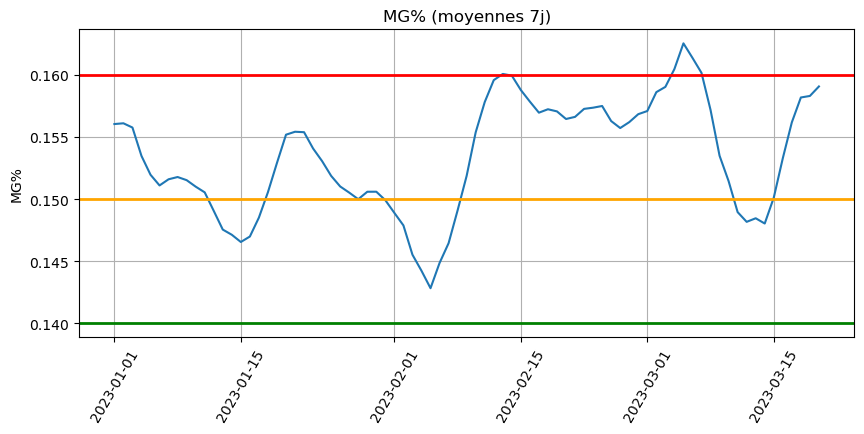

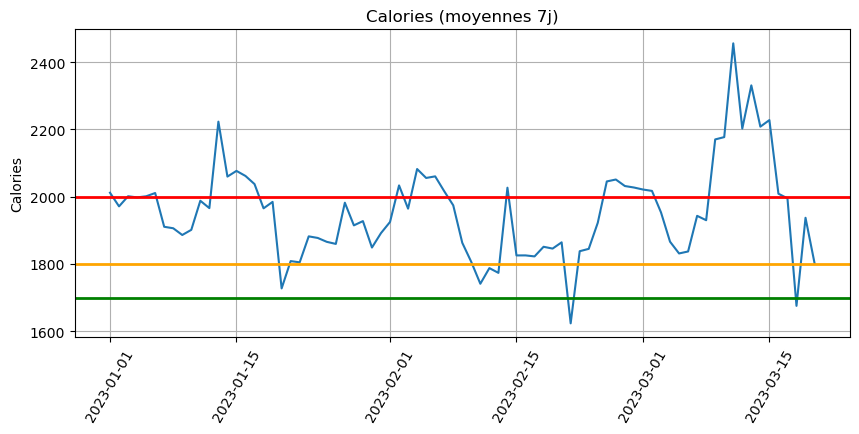

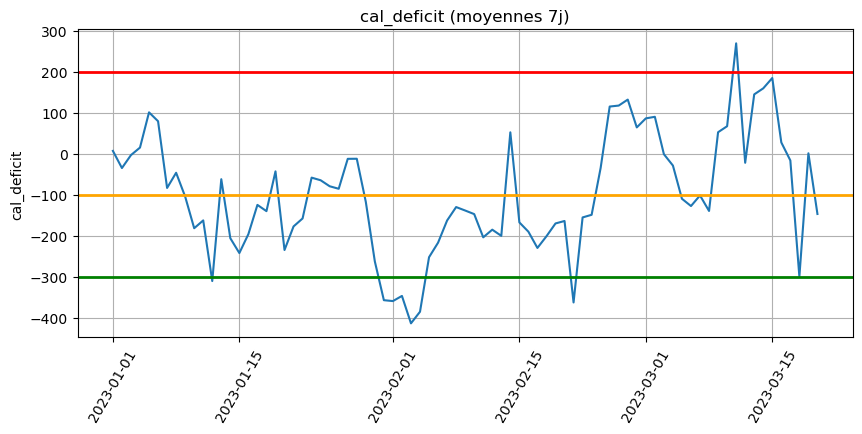

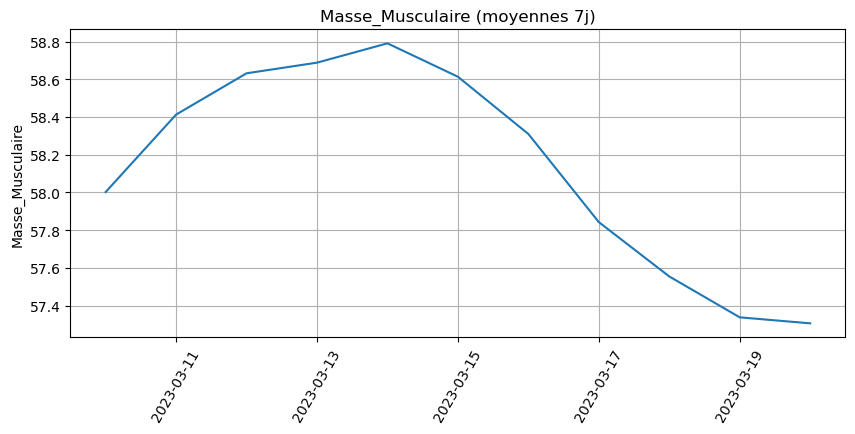

In [30]:
plot_general(longueur=7)

In [31]:
vars = ['MG%', 'Calories', 'cal_deficit'] # 'Masse_Grasse', 'BMR', 'Masse_Totale', 'exo_cals_nets', 'Masse_Musculaire', 

ipywidgets.interact(plot_general, longueur=(1,90,7), year=(2020,2023,1), month=(1,12,1))

interactive(children=(IntSlider(value=15, description='longueur', max=90, min=1, step=7), IntSlider(value=2023…

<function __main__.plot_general(longueur=15, year=2023, month=1, day=1)>

In [32]:
def plot_general2(longueur=15,
                 year=2022,
                 month=11,
                 day=1,
):
    # vars = ['Masse_Totale', 'MG%', 'BMR', 'Calories', 'cal_deficit']
    
    subset = ['Masse_Totale', 'Masse_Grasse'] # on permet des NaN en masse osseuse, etc en attendant d'avoir des data
    df_all2 = df_all.rolling(longueur).mean().dropna(subset = subset)
    start_date = datetime.date(year=year, month=month, day=day)

    df_all2 = df_all2[df_all2.index >= start_date]

    fig, ax = plt.subplots(figsize=(12,5))
    
    x = df_all2.index
    y1 = df_all2['MG%']
    ax.plot(y1, marker='x', color='red', label='MG%')
    ax.set_ylabel('MG%')
    ax.set_ylim(bottom=0.11, top=0.16)
    ax.tick_params(axis='x', labelrotation=60)
    ax.legend()
    ax.grid()
    
    y2 = df_all2['cal_deficit']
    ax2 = ax.twinx()
    ax2.plot(y2, marker='o', color='blue', label='cal_deficit')
    ax2.set_ylabel('cal_deficit')
    ax2.set_ylim(bottom=-500.0, top=300.0)
    # ax2.legend()

In [33]:
ipywidgets.interact(plot_general2, longueur=(1,90,7), year=(2020,2023,1), month=(1,12,1), day=(1))

interactive(children=(IntSlider(value=15, description='longueur', max=90, min=1, step=7), IntSlider(value=2022…

<function __main__.plot_general2(longueur=15, year=2022, month=11, day=1)>

In [34]:
def plot_general3(longueur=15,
                 year=2022,
                 month=11,
                 day=1
):
    # vars = ['Masse_Totale', 'MG%', 'BMR', 'Calories', 'cal_deficit']
    
    subset = ['Masse_Totale', 'Masse_Grasse'] # on permet des NaN en masse osseuse, etc en attendant d'avoir des data
    df_all2 = df_all.rolling(longueur).mean().dropna(subset = subset)
    start_date = datetime.date(year=year, month=month, day=day)

    df_all2 = df_all2[df_all2.index >= start_date]

    fig, ax = plt.subplots(figsize=(12,5))
    
    x = df_all2.index
    y1 = df_all2['MG%']
    ax.plot(y1, marker='x', color='red', label='MG%')
    ax.set_ylabel('MG%')
    ax.set_ylim(bottom=0.11, top=0.16)
    ax.tick_params(axis='x', labelrotation=60)
    ax.legend()
    ax.grid()
    
    y2 = df_all2['Calories']
    ax2 = ax.twinx()
    ax2.plot(y2, marker='o', color='blue', label='cal_deficit')
    ax2.set_ylabel('Calories')
    ax2.set_ylim(bottom=1700.0, top=2500.0)
    # ax2.legend()

In [35]:
ipywidgets.interact(plot_general3, longueur=(1,90,7), year=(2020,2023,1), month=(1,12,1), day=(1))

interactive(children=(IntSlider(value=15, description='longueur', max=90, min=1, step=7), IntSlider(value=2022…

<function __main__.plot_general3(longueur=15, year=2022, month=11, day=1)>